## Accessing SDSS Images Using Python ##

This notebook describes how to access SDSS images and view them.

You need to have astroquery installed.

http://www.astropy.org/astroquery/

Written by Rose A. Finn, October 19, 2017

In [31]:
from astroquery.sdss import SDSS
from astroquery.ned import Ned
from astropy import coordinates as coords
import astropy.units as u
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from astropy.io import fits
import wget
from scipy.stats import scoreatpercentile
import os

### NED Query ###
Using NED to find the coordinates of an object that we know the name of.

In [33]:
galaxy_name = 'NGC5320'
result_table = Ned.query_object(galaxy_name)

In [34]:
print result_table.columns

<TableColumns names=('No.','Object Name','RA(deg)','DEC(deg)','Type','Velocity','Redshift','Redshift Flag','Magnitude and Filter','Distance (arcmin)','References','Notes','Photometry Points','Positions','Redshift Points','Diameter Points','Associations')>


In [35]:
print result_table['RA(deg)'][0]

207.58491


define the position of the galaxy as a SkyCoord.  We use frame='icrs', the International Celestial Reference System.

In [6]:
pos = coords.SkyCoord(ra=result_table['RA(deg)'][0]*u.deg,dec=result_table['DEC(deg)'][0]*u.deg, frame='icrs')

## SDSS Query  to get object info ##
Now we can query SDSS for the image

In [7]:
xid = SDSS.query_region(pos)

In [8]:
print xid

      ra           dec             objid        run  rerun camcol field
------------- ------------- ------------------- ---- ----- ------ -----
  207.5849322 41.3662157091 1237662196144472099 3893   301      6   287
207.584934002  41.366215011 1237662196144472096 3893   301      6   287


In [9]:
sdsscoords = coords.SkyCoord(ra = xid['ra']*u.deg, dec=xid['dec']*u.deg,frame='icrs')

In [16]:
distance = pos.separation(sdsscoords)
match = (distance == min(distance))
print match
#match = np.arange(len(distance)) == 2
print xid[match]

[ True False]
     ra          dec             objid        run  rerun camcol field
----------- ------------- ------------------- ---- ----- ------ -----
207.5849322 41.3662157091 1237662196144472099 3893   301      6   287


In [17]:
im = SDSS.get_images(matches = xid[match], band='r')

object =       ra          dec             objid        run  rerun camcol field
----------- ------------- ------------------- ---- ----- ------ -----
207.5849322 41.3662157091 1237662196144472099 3893   301      6   287
band =  r
http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/3893/6/frame-r-003893-6-0287.fits.bz2


This returns "lists of HDUList objects, one entry for each corresponding object in xid." (http://astroquery.readthedocs.io/en/latest/sdss/sdss.html)  

This is not the image I was looking for... Doesn't appear to download anything.  The call behaves the same way in ipython :(

## Retrieve Image Using wget ##

This is a workaround until I figure out how to actually get the image from SDSS.get_images().

In [18]:
run = (xid[match]['run'][0])
rerun = xid[match]['rerun'][0]
camcol = xid[match]['camcol'][0]
field = (xid[match]['field'][0])
band = 'r'

In [19]:
# taking a lot of this from core.py in astropy.sdss
baseurl = 'http://data.sdss3.org/sas'
IMAGING_URL_SUFFIX = ('{base}/dr{dr}/boss/photoObj/frames/'
                          '{rerun}/{run:04d}/{camcol}/'
                          'frame-{band}-{run:06d}-{camcol}-'
                          '{field:04d}.fits.bz2')
f = IMAGING_URL_SUFFIX.format(base=baseurl,run=run,dr='12',rerun=rerun,camcol=camcol,band=band,field=field)
print f

http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/3893/6/frame-r-003893-6-0287.fits.bz2


In [20]:
imfile = wget.download(f)

In [21]:
imdat = fits.getdata(imfile)

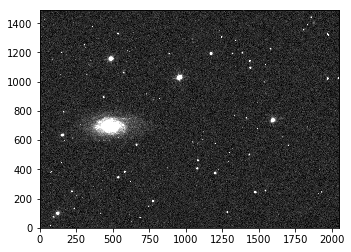

In [27]:
plt.imshow(imdat,origin='lower',vmin=scoreatpercentile(imdat,.5),vmax=scoreatpercentile(imdat,99.5),cmap='gray')

## Get PSF Image ##

Details on url format at http://www.sdss.org/dr12/imaging/pipeline/ under Postage Stamp Pipeline.

We use the C program read_PSF from http://www.sdss.org/wp-content/uploads/2014/10/readAtlasImages-v5_4_11.tar.gz to construct the PSF images from the psField files.  

To install on Mac

* in untarred directory, type make
* then I linked the executables (read_PSF, read_atlas_image, read_mask) to /usr/local/bin/

On coma (linux machine)

* make CCCHK="-DSDSS_LITTLE_ENDIAN"
* then link executables.  Move to /usr/local/bin/ and then
    * sudo ln -s ~/software/readAtlasImages-v5_4_11/read_PSF read_PSF
    * sudo ln -s ~/software/readAtlasImages-v5_4_11/read_atlas_image read_atlas_image
    * sudo ln -s ~/software/readAtlasImages-v5_4_11/read_mask read_mask
    




In [28]:
# construct the url for the psField file
baseurl = 'http://data.sdss3.org/sas'
IMAGING_URL_SUFFIX = ('{base}/dr{dr}/boss/photo/redux/'
                          '{rerun}/{run:04d}/objcs/{camcol}/'
                          'psField-{run:06d}-{camcol}-'
                          '{field:04d}.fit')
psf = IMAGING_URL_SUFFIX.format(base=baseurl,run=run,dr='12',rerun=rerun,camcol=camcol,band=band,field=field)
print psf
#boss/photo/redux/%d/%d/objcs/%d/psField-%06d-%d-%04d.fit

http://data.sdss3.org/sas/dr12/boss/photo/redux/301/3893/objcs/6/psField-003893-6-0287.fit


In [29]:
# download the psField file
psfield_file = wget.download(psf)

In [30]:
# read in the psField
sdssbands = {'u':1,'g':2,'r':3,'i':4,'z':5}

Need to specify the row and column that the galaxy is located at.

In [37]:
row = 500
col = 500
band = 'r'

In [46]:
t=os.getcwd()
psf_image = t+'/'+galaxy_name+'-psf.fits'
print 'Run the following command from the linux prompt: \n'
print 'read_PSF '+psfield_file+' '+str(sdssbands[band]-1) +' '+str(row)+' '+str(col)+psf_image
#os.system('read_PSF '+psfield_file+' '+str(sdssbands[band]-1) +' '+str(row)+' '+str(col)+psf_image)

Run the following command from the linux prompt: 

read_PSF psField-003893-6-0287.fit 2 500 500/Users/rfinn/Dropbox/git/astro-tutorials/NGC5320-psf.fits


## End of Useful Stuff ##

In [ ]:
psf = fits.getdata(psf_image)
plt.imshow(psf)

In [67]:
# recall u,g,r,i,z == 0,1,2,3,4 so just add one to the index
pstruct = fits.getdata(psfield_file,ext=sdssbands[band])

In [68]:
pstruct.columns

ColDefs(
    name = 'nrow_b'; format = '1J'
    name = 'ncol_b'; format = '1J'
    name = 'c'; format = '25E'; dim = '(5,5)'
    name = 'lambda'; format = '1E'
    name = 'RNROW'; format = '1J'
    name = 'RNCOL'; format = '1J'
    name = 'RTYPE'; format = '1J'
    name = 'RROWS'; format = '1PE(0)'
    name = 'RROW0'; format = '1J'
    name = 'RCOL0'; format = '1J'
    name = 'counts'; format = '1E'
)

In [69]:
# set position on image for now
row = 500
col = 500

In [70]:
pstruct['c'][:,0]

array([[  5.07285131e-06,  -7.02059083e-07,   2.38608266e-07,
          5.95596539e-34,   3.08285662e-44],
       [ -2.17091256e-05,   3.93571536e-05,  -1.45490903e-05,
          5.95737598e-34,   8.40779079e-45],
       [ -3.11879885e-05,   5.31262849e-05,  -1.96730471e-05,
          0.00000000e+00,   3.36311631e-44],
       [ -1.13219994e-05,   3.23350323e-05,  -1.66287300e-05,
         -4.21333406e-03,  -1.69464238e-02]], dtype=float32)

In [ ]:
#
# from https://github.com/esheldon/sdsspy/blob/master/sdsspy/atlas/psf.py
#
# trying to pull the math without all of the other module stuff

nrow_b = pstruct['nrow_b'][0]
ncol_b = pstruct['ncol_b'][0]
nb = nrow_b*ncol_b
coeffs = np.zeros(nb, dtype='f4')
cmat = pstruct['c']
try:
    rcs = pstruct['RC_SCALE']
except:
    rcs = 0.001 #this is what the idl code does

for i in range(nb):
    coeffs[i]=(row*rcs)**(i % nrow_b) * (col*rcs)**(i//nrow_b)


ncomp = 3
ecoeffs = np.zeros(ncomp, dtype='f4')


for j in range(ncomp):
    cmat = pstruct['c'][j]
    for i in range(nb):
        ecoeffs[j] += cmat[i % nrow_b, i//nrow_b] * coeffs[i]

        
psf = np.zeros(pstruct['rrows'].shape,'f')
print pstruct['rrows'][2]
print psf.shape
psf = pstruct['rrows'][0]*ecoeff[0] + \
    pstruct['rrows'][1]*ecoeff[1] + \
    pstruct['rrows'][2]*ecoeff[2]

'''  

image = ecoeffs[0]*pstruct['lambda'][0]
for i in range(1,ncomp):
    image[:,:] += ecoeffs[i]*pstruct['lambda'][i][:,:]

if trim:
    image = image[10:41, 10:41]

if counts is not None:
    fac = counts/image.sum()
    image *= fac

if more:
    out={}
    out['coeffs'] = coeffs
    out['ecoeffs'] = ecoeffs
    out['image'] = image
    #return out
else:
    print 'hi'
    #return image
'''


In [ ]:
# reconstruct the psf
nrow_b = pstruct['nrow_b'][0]
ncol_b = pstruct['ncol_b'][0]
# assumes they are the same for each eigen so only use the 0 one
rnrow = pstruct['rnrow'][0]
rncol = pstruct['rncol'][0]
nb=nrow_b*ncol_b
coeffs=np.zeros(nb,'f4')
ncomp = pstruct['ncomp']
ecoeff=np.zeros(ncomp,'f4')
cmat=pstruct['c']
#print cmat
rcs=pstruct['RC_SCALE']

In [69]:
for i in range(len(coeffs)): 
    coeffs[i]=(row*rcs)**(i % nrow_b) * (col*rcs)**(i/nrow_b)
print coeffs


[ 1.      0.5     0.25    0.5     0.25    0.125   0.25    0.125   0.0625]


In [70]:
for j in range(len(ecoeff)):
    for i in range(len(coeffs)): 
        ecoeff[j]=ecoeff[j]+cmat[i/nrow_b,i % nrow_b,j]*coeffs[i]
print ecoeff

[  2.37228005e-06   7.27222050e-06  -2.80828726e-06]


## Download the image using urllib ##

This is some code I wrote when running galfit on SDSS images for the LCS project.  I don't see any advantage at this point over wget, and certainly astroquery.SDSS would be even better if we can get that to work.  EXCEPT, this code also downloads the PSF image, so I will need to recreate that.

In [ ]:
######################
#
# Get SDSS Images
#
######################
            
def getsdssimage(field,run,rerun,camcol,row,col)
    tmp_run='%06d'%(run)
    tmp_field='%04d'%(field)
    sdss_path_c = "imaging/"+str(run)+"/"+str(rerun)+"/corr/"+str(camcol)+"/"
    sdss_corr_name_g = "fpC-"+tmp_run+"-g"+str(camcol)+"-"+tmp_field+".fit"
    sdss_corr_name_r = "fpC-"+tmp_run+"-r"+str(camcol)+"-"+tmp_field+".fit"
    url="http://das.sdss.org/"+sdss_path_c+sdss_corr_name_g+'.gz'
    #http://data.sdss3.org/sas/dr12/boss/photoObj/frames/301/1043/3/frame-g-001043-3-0015.fits.bz2
    # updating program to use drC file instead of fpC image
    # looks like rowc and colc are the positions on the drC file
    #

    #   The DAS can generate "header supplemented" versions of the fpC files, called drC files.
    #   These are the same as the fpC files, except have newly generated header values for a number
    #   of parameters, including FLUX20 and SKY, derived from the data in the tsField file. (The
    #   DAS generates these "on the fly" from the fpC and tsField files on disk, so you need to use
    #   the http interface rather than the rsync interface to get them.)

    #   e.g. http://das.sdss.org/www/cgi-bin/drC?RUN=3805&RERUN=41&CAMCOL=3&FIELD=96&FILTER=r

    sdss_drC_name_r = "drC-"+tmp_run+"-r"+str(camcol)+"-"+str(rerun)+"-"+tmp_field+".fits"
    drCurl="http://das.sdss.org/www/cgi-bin/drC?RUN=%s&RERUN=%s&CAMCOL=%s&FIELD=%s&FILTER=r"%(str(run),str(rerun),str(camcol),str(field))
    urllib.urlretrieve(drCurl,filename=sdss_drC_name_r)
    # display sdss image
    #d.set('file %s'%(sdss_drC_name_r))
    # get psField file to use when reconstructing the PSF
    sdss_path_o = "imaging/"+str(run)+"/"+str(rerun)+"/objcs/"+str(camcol)+"/"
    sdss_ps_name_r = "psField-"+tmp_run+"-"+str(camcol)+"-"+tmp_field+".fit"

    psurl="http://das.sdss.org/"+sdss_path_o+sdss_ps_name_r
    urllib.urlretrieve(psurl,filename=sdss_ps_name_r)

    #  need to rewrite this to use astropy
    #iraf.imgets(image=working_dir+sdss_drC_name_r,param='FLUX20')
    #flux20=float(iraf.imgets.value)
    #iraf.imgets(image=working_dir+sdss_drC_name_r,param='EXPTIME')
    #exptime=float(iraf.imgets.value)
    #iraf.imgets(image=working_dir+sdss_drC_name_r,param='ZP')
    #magzp=float(iraf.imgets.value) - 2.5*log10(exptime)
    #iraf.imgets(image=working_dir+sdss_drC_name_r,param='SKY')
    #sky=float(iraf.imgets.value)
    
    
    # construct PSF, given row, col in image
    #
    # read_PSF psField.... .fit 2 row col output.fit

    psf_image=prefix+'-'+str(n.NSAID[i])+'-'+'SDSS-PSF.fits'
    sky_sub_psf_image=prefix+'-'+str(n.NSAID[i])+'-'+'SDSS-PSF-SKY.fits'
    s='read_PSF '+sdss_ps_name_r+' 2 '+str(row)+' '+str(col)+' '+psf_image
    os.system(s)
    # subtract 1000 ADU pedestal from psf image
    try:
        iraf.imarith(psf_image,'-','1000.',sky_sub_psf_image)
    except:
        print 'Warning:  Problem creating bias-subtracted PSF image, probably b/c it already exists'
        print '   going to delete bias-subtracted PSF image and try imarith again'
        iraf.imdel(sky_sub_psf_image)
        iraf.imarith(psf_image,'-','1000.',sky_sub_psf_image)


    # get image parameters (GAIN, dark_variance) from tsfield file
            
    sdss_path_calib = "imaging/"+str(run)+"/"+str(rerun)+"/calibChunks/"+str(camcol)+"/"
    sdss_ts_name_r = "tsField-"+tmp_run+"-"+str(camcol)+"-"+str(rerun)+"-"+tmp_field+".fit"
    tsurl="http://das.sdss.org/"+sdss_path_calib+sdss_ts_name_r
    urllib.urlretrieve(tsurl,filename=sdss_ts_name_r)
    
    # need to update this section to use astropy
    #tsfield=atpy.Table(working_dir+sdss_ts_name_r)
    #gain=tsfield.gain[0]
    #gain_r=gain[2]
    #psfwidth=tsfield.psf_width[0]
    #psfwidth_r=psfwidth[2]
    #darknoise=tsfield.dark_variance[0]
    #darknoise_r=darknoise[2]
    #magzp=20.+2.5*log10(flux20/exptime)


######################
#
# End of getting SDSS Images
#
######################

In [ ]:
# recall u,g,r,i,z == 0,1,2,3,4 so just add one to the index
pstruct = fits.getdata(psfield_file, 3)
nrow_b=(pstruct.nrow_b)[0]
ncol_b=(pstruct.ncol_b)[0]
;assumes they are the same for each eigen so only use the 0 one
rnrow=(pstruct.rnrow)[0]
rncol=(pstruct.rncol)[0]
nb=nrow_b*ncol_b
coeffs=fltarr(nb)
ecoeff=fltarr(3)
cmat=pstruct.c
rcs=0.001
FOR i=0L, nb-1L DO coeffs[i]=(row*rcs)^(i mod nrow_b) * (col*rcs)^(i/nrow_b)
FOR j=0,2 DO BEGIN
    FOR i=0L, nb-1L DO BEGIN
        ecoeff[j]=ecoeff[j]+cmat(i/nrow_b,i mod nrow_b,j)*coeffs[i]
    ENDFOR
ENDFOR
psf = (pstruct.rrows)[*,0]*ecoeff[0]+$
      (pstruct.rrows)[*,1]*ecoeff[1]+$
      (pstruct.rrows)[*,2]*ecoeff[2]